In [ ]:
# ====== Imports ======
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

In [ ]:
# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# ====== 1) Load CIFAR-10 ======
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("Train:", x_train.shape, y_train.shape, "Test:", x_test.shape, y_test.shape)

Train: (50000, 32, 32, 3) (50000, 1) Test: (10000, 32, 32, 3) (10000, 1)


In [ ]:
# ====== 2) Preprocessing ======
# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [ ]:
# One-hot encode labels (for categorical_crossentropy)
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

In [ ]:
# Optionally create a validation split from training
val_split = 0.1
val_size = int(len(x_train) * val_split)
x_val = x_train[-val_size:]
y_val_cat = y_train_cat[-val_size:]
x_train2 = x_train[:-val_size]
y_train_cat2 = y_train_cat[:-val_size]

print("After split -> train:", x_train2.shape, "val:", x_val.shape)

After split -> train: (45000, 32, 32, 3) val: (5000, 32, 32, 3)


In [ ]:
# ====== Data augmentation ======
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train2)

In [ ]:
# ====== 3) Build the CNN model ======
def build_model(input_shape=(32,32,3), num_classes=10, activation='relu', weight_init='he_normal'):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Block 1
    x = layers.Conv2D(32, (3,3), padding='same', kernel_initializer=weight_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(32, (3,3), padding='same', kernel_initializer=weight_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), padding='same', kernel_initializer=weight_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(64, (3,3), padding='same', kernel_initializer=weight_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.35)(x)

    # Block 3
    x = layers.Conv2D(128, (3,3), padding='same', kernel_initializer=weight_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(128, (3,3), padding='same', kernel_initializer=weight_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, kernel_initializer=weight_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Build with ReLU and He init (recommended)
model = build_model(activation='relu', weight_init='he_normal')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
# ====== 4) Compile: optimizer, loss, metrics ======
initial_lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',     
    metrics=['accuracy']
)


In [ ]:
# ====== 5) Callbacks ======
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_cifar10_model.h5", save_best_only=True, monitor='val_accuracy', mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
]


In [ ]:
# ====== 6) Train the model======
batch_size = 64
epochs = 10

history = model.fit(
    datagen.flow(x_train2, y_train_cat2, batch_size=batch_size),
    steps_per_epoch=len(x_train2)//batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val_cat),
    callbacks=callbacks
)


Epoch 1/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.5524 - loss: 1.2418

703/703 ━━━━━━━━━━━━━━━━━━━━ 501s 712ms/step - accuracy: 0.5525 - loss: 1.2417 - val_accuracy: 0.6410 - val_loss: 1.0204 - learning_rate: 0.0010
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.6250 - loss: 1.0981 - val_accuracy: 0.6380 - val_loss: 1.0412 - learning_rate: 0.0010
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.6062 - loss: 1.1071

703/703 ━━━━━━━━━━━━━━━━━━━━ 462s 657ms/step - accuracy: 0.6062 - loss: 1.1071 - val_accuracy: 0.6928 - val_loss: 0.8766 - learning_rate: 0.0010
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.5312 - loss: 1.1351 - val_accuracy: 0.6918 - val_loss: 0.8759 - learning_rate: 0.0010
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 452s 644ms/step - accuracy: 0.6439 - loss: 1.0081 - val_accuracy: 0.5846 - val_loss: 1.3112 - learning_rate: 0.0010
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.6875 - loss: 0.8270 - val_accuracy: 0.5890 - val_loss: 1.3021 - learning_rate: 0.0010
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.6681 - loss: 0.9430

703/703 ━━━━━━━━━━━━━━━━━━━━ 455s 647ms/step - accuracy: 0.6681 - loss: 0.9430 - val_accuracy: 0.7178 - val_loss: 0.8132 - learning_rate: 0.0010
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.6719 - loss: 0.9982 - val_accuracy: 0.7122 - val_loss: 0.8242 - learning_rate: 0.0010
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 488s 657ms/step - accuracy: 0.6895 - loss: 0.8852 - val_accuracy: 0.6888 - val_loss: 0.9186 - learning_rate: 0.0010
Epoch 10/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.6875 - loss: 0.9815 - val_accuracy: 0.6910 - val_loss: 0.9123 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 7.


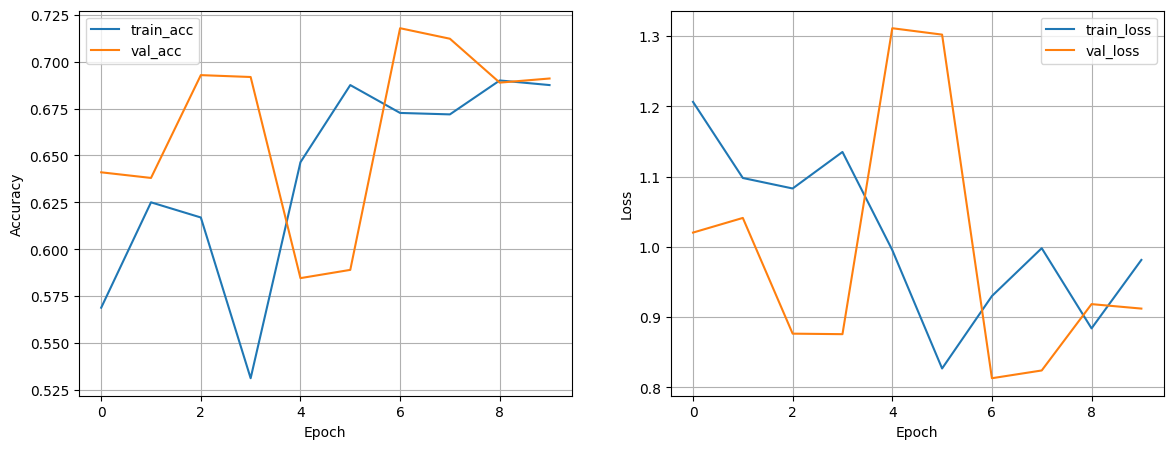

In [ ]:
# ====== 7) Plot training curves ======
def plot_history(h):
    plt.figure(figsize=(14,5))
    # accuracy
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    # loss
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.show()

plot_history(history)


In [ ]:
# ====== 8) Evaluate on test set ======
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=2)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

# Predictions & classification report
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

313/313 - 23s - 73ms/step - accuracy: 0.6988 - loss: 0.8635
Test accuracy: 0.6988, Test loss: 0.8635
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step


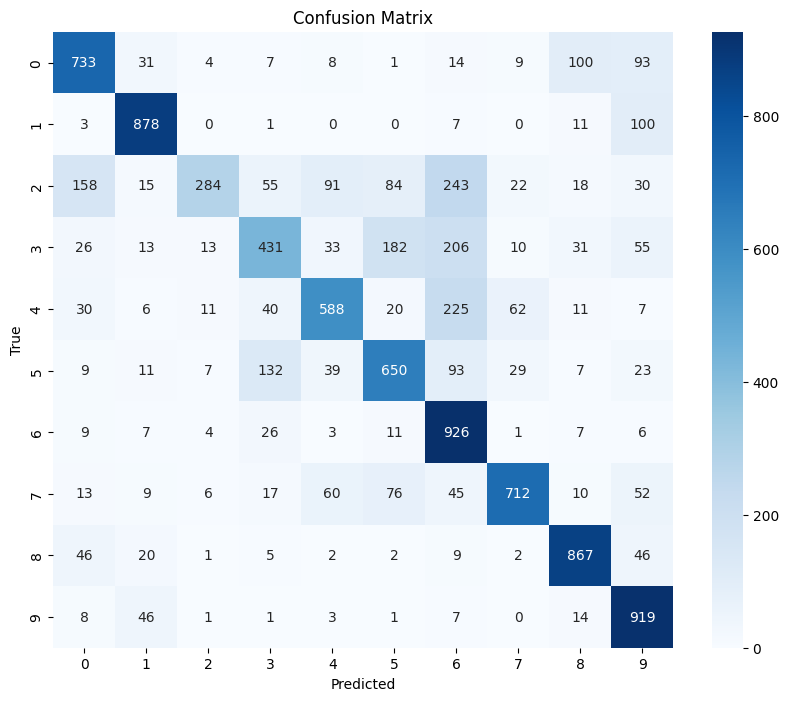

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report (precision, recall, f1)
report = classification_report(y_true, y_pred, target_names=[
    'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])
print(report)


              precision    recall  f1-score   support

    airplane       0.71      0.73      0.72      1000
  automobile       0.85      0.88      0.86      1000
        bird       0.86      0.28      0.43      1000
         cat       0.60      0.43      0.50      1000
        deer       0.71      0.59      0.64      1000
         dog       0.63      0.65      0.64      1000
        frog       0.52      0.93      0.67      1000
       horse       0.84      0.71      0.77      1000
        ship       0.81      0.87      0.84      1000
       truck       0.69      0.92      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.72      0.70      0.69     10000
weighted avg       0.72      0.70      0.69     10000



In [ ]:
# ====== 9) Save model and provide instructions for Colab/GitHub ======
model.save('cifar10_cnn_final.h5')
print("Model saved to cifar10_cnn_final.h5")


Model saved to cifar10_cnn_final.h5


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving cat.jpeg to cat.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted class: cat


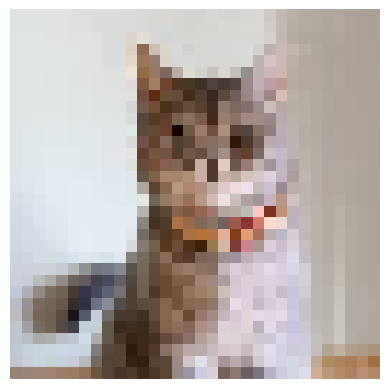

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Replace 'your_image.jpg' with the uploaded file name
img_path = list(uploaded.keys())[0]

# Load & resize to 32x32
img = image.load_img(img_path, target_size=(32,32))

# Convert to array and normalize
img_array = image.img_to_array(img) / 255.0

# Expand dimensions to match model input (1,32,32,3)
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred_probs = model.predict(img_array)
pred_class = np.argmax(pred_probs, axis=1)[0]

# Map class index to label
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print(f"Predicted class: {class_names[pred_class]}")

# Show the image
plt.imshow(img)
plt.axis('off')
plt.show()
